In [1]:
!pip install tensorflow-federated

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.6/721.6 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.9/230.9 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61

In [3]:
!pip install --upgrade tensorflow_federated

# **Dataset**

In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/CICIoV2024/decimal.csv')
data


,ID,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7,label,category,specific_class
0,65,96,0,0,0,0,0,0,0,BENIGN,BENIGN,BENIGN
1,1068,132,13,160,0,0,0,0,0,BENIGN,BENIGN,BENIGN
2,535,127,255,127,255,127,255,127,255,BENIGN,BENIGN,BENIGN
3,131,15,224,0,0,0,0,0,0,BENIGN,BENIGN,BENIGN
4,936,1,0,39,16,0,0,0,0,BENIGN,BENIGN,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...
1408214,128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL
1408215,128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL
1408216,128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL
1408217,128,132,3,2,35,24,5,138,34,ATTACK,SPOOFING,STEERING_WHEEL


# **Binary Classification using "label"**

**2 clients, 2D conv, SGD, lr=0.01**

In [6]:
import pandas as pd
import numpy as np
import collections
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.model_selection import train_test_split

# Load the dataset
#df = pd.read_csv("decimal2.csv")
df = pd.read_csv("/content/drive/MyDrive/CICIoV2024/decimal.csv")

# Encode string labels into numerical values
label_mapping = {label: index for index, label in enumerate(df['label'].unique())}
df['label'] = df['label'].map(label_mapping)

# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

## Create train data for two clients
def create_tf_dataset_for_client(client_data):
    data = client_data.iloc[:, 1:9].values.astype(np.float32)
    labels = client_data['label'].values.astype(np.int32)
    return tf.data.Dataset.from_tensor_slices((data, labels)).batch(32)

# Split the train_df into two parts for two clients
client_0_data, client_1_data = train_test_split(train_df, test_size=0.5, random_state=42)

# Create TF datasets for each client
train_data = [
    create_tf_dataset_for_client(client_0_data),
    create_tf_dataset_for_client(client_1_data)
]

# Create a TF dataset for the test data
test_data = tf.data.Dataset.from_tensor_slices(
    (test_df.iloc[:, 1:9].values.astype(np.float32), test_df['label'].values.astype(np.int32))
).batch(32)

# Wrap a Keras model for use with TFF.
def model_fn():
    keras_model = tf.keras.models.Sequential([
        tf.keras.layers.Reshape((8, 1), input_shape=(8,)),
        tf.keras.layers.Conv1D(32, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(64, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(np.max(df['label']) + 1, activation='softmax')
    ])
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=train_data[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

# Simulate a few rounds of training with the selected client devices.
trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01)
)

state = trainer.initialize()
eval_process = tff.learning.algorithms.build_fed_eval(model_fn)
evaluation_state = eval_process.initialize()

print("Training and Testing Results")
for round_num in range(5):
    state, metrics = trainer.next(state, train_data)

    train_accuracy = metrics['client_work']['train']['sparse_categorical_accuracy']
    train_loss = metrics['client_work']['train']['loss']
    num_examples = metrics['client_work']['train']['num_examples']
    num_batches = metrics['client_work']['train']['num_batches']
    print(f'Round {round_num+1}, Training accuracy: {train_accuracy:.4f}, Training loss: {train_loss:.4f}, Num examples: {num_examples}, Num batches: {num_batches}')

    #eval_process = tff.learning.build_federated_evaluation(model_fn)
    #eval_process = tff.learning.algorithms.build_fed_eval(model_fn)
    model_weights = trainer.get_model_weights(state)
    test_metrics = eval_process(model_weights, [test_data])['eval']
    evaluation_state = eval_process.set_model_weights(evaluation_state, model_weights)
    print(f"Round {round_num+1}, Evaluation accuracy : {test_metrics['sparse_categorical_accuracy']}, Evaluation loss : {test_metrics['loss']},  Num examples: {test_metrics['num_examples']}, Num batches: {test_metrics['num_batches']}")


Training and Testing Results
Round 1, Training accuracy: 0.9274, Training loss: 1.0546, Num examples: 1126575, Num batches: 35206


TypeError: 'LearningProcess' object is not callable

**2 clients, 1D conv, Adam, lr=0.001**

In [4]:
import pandas as pd
import numpy as np
import collections
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/CICIoV2024/decimal.csv")

# Encode string labels into numerical values
label_mapping = {label: index for index, label in enumerate(df['label'].unique())}
df['label'] = df['label'].map(label_mapping)

# Split the data into train and test sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

## Create train data for two clients
def create_tf_dataset_for_client(client_data):
    data = client_data.iloc[:, 1:9].values.astype(np.float32)
    labels = client_data['label'].values.astype(np.int32)
    return tf.data.Dataset.from_tensor_slices((data, labels)).batch(32)

# Split the train_df into two parts for two clients
client_0_data, client_1_data = train_test_split(train_df, test_size=0.5, random_state=42)

# Create TF datasets for each client
train_data = [
    create_tf_dataset_for_client(client_0_data),
    create_tf_dataset_for_client(client_1_data)
]

# Create a TF dataset for the test data
test_data = tf.data.Dataset.from_tensor_slices(
    (test_df.iloc[:, 1:9].values.astype(np.float32), test_df['label'].values.astype(np.int32))
).batch(32)

# Define the Keras model
def build_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Reshape((8, 1), input_shape=(8,)),
        tf.keras.layers.Conv1D(32, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(64, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(np.max(df['label']) + 1, activation='softmax')
    ])
    return model

# Wrap a Keras model for use with TFF.
def model_fn():
    keras_model = build_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=train_data[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

# Simulate a few rounds of training with the selected client devices.
trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.001)
)

state = trainer.initialize()

# Lists to store training and testing metrics
train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []

print("Training and Testing Results")

for round_num in range(2):
    # Training
    state, metrics = trainer.next(state, train_data)

    train_accuracy = metrics['client_work']['train']['sparse_categorical_accuracy']
    train_loss = metrics['client_work']['train']['loss']
    num_examples = metrics['client_work']['train']['num_examples']
    num_batches = metrics['client_work']['train']['num_batches']
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    print(f'Round {round_num+1}, Training accuracy: {train_accuracy:.4f}, Training loss: {train_loss:.4f}, Num examples: {num_examples}, Num batches: {num_batches}')

    # Testing
    eval_process = tff.learning.build_federated_evaluation(model_fn)
    model_weights = trainer.get_model_weights(state)
    test_metrics = eval_process(model_weights, [test_data])['eval']
    test_accuracy = test_metrics['sparse_categorical_accuracy']
    test_loss = test_metrics['loss']
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)
    print(f"Round {round_num+1}, Testing accuracy: {test_accuracy:.4f}, Testing loss: {test_loss:.4f}, Num examples: {test_metrics['num_examples']}, Num batches: {test_metrics['num_batches']}")

rounds = range(1, 3)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(rounds, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(rounds, test_accuracies, marker='o', label='Test Accuracy')
plt.title('Accuracy over Rounds')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rounds, train_losses, marker='o', label='Train Loss')
plt.plot(rounds, test_losses, marker='o', label='Test Loss')
plt.title('Loss over Rounds')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()

plt.suptitle('Federated Training and Testing Plot')
plt.show()


# Confusion Matrix
keras_model = build_keras_model()
keras_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
keras_model.set_weights(model_weights.trainable)

y_true = np.concatenate([y for x, y in test_data], axis=0)
y_pred = np.argmax(keras_model.predict(test_data), axis=1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
disp.plot()
plt.title('Confusion Matrix')
plt.show()


from sklearn.metrics import roc_curve, auc

# After obtaining model predictions
y_prob = keras_model.predict(test_data)

# Compute fpr, tpr, thresholds and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_prob, pos_label=None)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print("AUC Score:", roc_auc)


Training and Testing Results
Round 1, Training accuracy: 0.9935, Training loss: 0.0202, Num examples: 1126575, Num batches: 35206


AttributeError: module 'tensorflow_federated.python.learning' has no attribute 'build_federated_evaluation'

Training and Testing Results
Round 1, Training accuracy: 0.9935, Training loss: 0.0224, Num examples: 1126575, Num batches: 35206


<ipython-input-1-489dce1cb2b8>:93: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(model_fn)


Round 2, Training accuracy: 0.9958, Training loss: 0.0180, Num examples: 1126575, Num batches: 35206
Round 3, Training accuracy: 0.9959, Training loss: 0.0174, Num examples: 1126575, Num batches: 35206
Round 4, Training accuracy: 0.9963, Training loss: 0.0110, Num examples: 1126575, Num batches: 35206
Round 5, Training accuracy: 0.9946, Training loss: 0.0382, Num examples: 1126575, Num batches: 35206


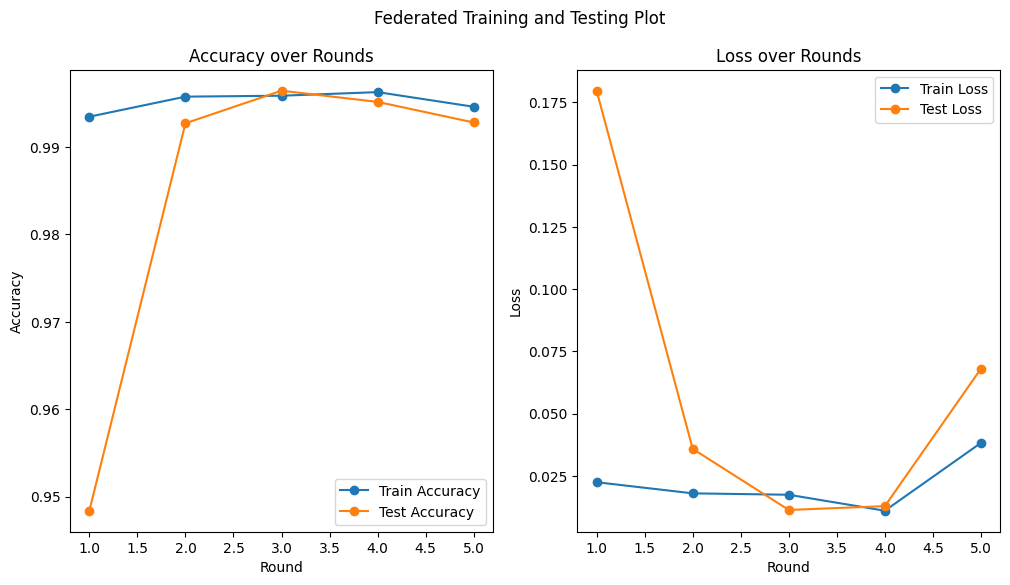

8802/8802 [==============================] - 16s 2ms/step


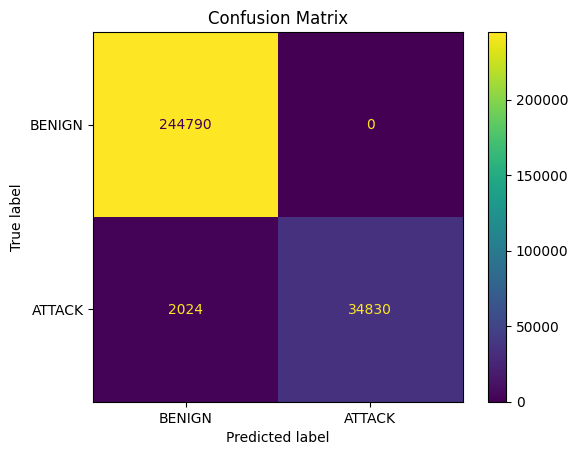

In [ ]:
import pandas as pd
import numpy as np
import collections
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/CICIoV2024/decimal.csv")

# Encode string labels into numerical values
label_mapping = {label: index for index, label in enumerate(df['label'].unique())}
df['label'] = df['label'].map(label_mapping)

# Split the data into train and test sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

## Create train data for two clients
def create_tf_dataset_for_client(client_data):
    data = client_data.iloc[:, 1:9].values.astype(np.float32)
    labels = client_data['label'].values.astype(np.int32)
    return tf.data.Dataset.from_tensor_slices((data, labels)).batch(32)

# Split the train_df into two parts for two clients
client_0_data, client_1_data = train_test_split(train_df, test_size=0.5, random_state=42)

# Create TF datasets for each client
train_data = [
    create_tf_dataset_for_client(client_0_data),
    create_tf_dataset_for_client(client_1_data)
]

# Create a TF dataset for the test data
test_data = tf.data.Dataset.from_tensor_slices(
    (test_df.iloc[:, 1:9].values.astype(np.float32), test_df['label'].values.astype(np.int32))
).batch(32)

# Define the Keras model
def build_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Reshape((8, 1), input_shape=(8,)),
        tf.keras.layers.Conv1D(32, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(64, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(np.max(df['label']) + 1, activation='softmax')
    ])
    return model

# Wrap a Keras model for use with TFF.
def model_fn():
    keras_model = build_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=train_data[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

# Simulate a few rounds of training with the selected client devices.
trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.001)
)

state = trainer.initialize()

# Lists to store training and testing metrics
train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []

print("Training and Testing Results")

for round_num in range(5):
    # Training
    state, metrics = trainer.next(state, train_data)

    train_accuracy = metrics['client_work']['train']['sparse_categorical_accuracy']
    train_loss = metrics['client_work']['train']['loss']
    num_examples = metrics['client_work']['train']['num_examples']
    num_batches = metrics['client_work']['train']['num_batches']
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    print(f'Round {round_num+1}, Training accuracy: {train_accuracy:.4f}, Training loss: {train_loss:.4f}, Num examples: {num_examples}, Num batches: {num_batches}')

    # Testing
    eval_process = tff.learning.build_federated_evaluation(model_fn)
    model_weights = trainer.get_model_weights(state)
    test_metrics = eval_process(model_weights, [test_data])['eval']
    test_accuracy = test_metrics['sparse_categorical_accuracy']
    test_loss = test_metrics['loss']
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)
    #print(f"Round {round_num+1}, Testing accuracy: {test_accuracy:.4f}, Testing loss: {test_loss:.4f}, Num examples: {test_metrics['num_examples']}, Num batches: {test_metrics['num_batches']}")

rounds = range(1, 6)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(rounds, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(rounds, test_accuracies, marker='o', label='Test Accuracy')
plt.title('Accuracy over Rounds')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rounds, train_losses, marker='o', label='Train Loss')
plt.plot(rounds, test_losses, marker='o', label='Test Loss')
plt.title('Loss over Rounds')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()

plt.suptitle('Federated Training and Testing Plot')
plt.show()


# Confusion Matrix
keras_model = build_keras_model()
keras_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
keras_model.set_weights(model_weights.trainable)

y_true = np.concatenate([y for x, y in test_data], axis=0)
y_pred = np.argmax(keras_model.predict(test_data), axis=1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
disp.plot()
plt.title('Confusion Matrix')
plt.show()


**5 clients, 1D conv, Adam, lr=0.001**

Training and Testing Results
Round 1, Training accuracy: 0.9894, Training loss: 0.0419, Num examples: 1126575, Num batches: 35210


<ipython-input-4-224098c35f1d>:90: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(model_fn)


Round 2, Training accuracy: 0.9952, Training loss: 0.0140, Num examples: 1126575, Num batches: 35210
Round 3, Training accuracy: 0.9958, Training loss: 0.0132, Num examples: 1126575, Num batches: 35210
Round 4, Training accuracy: 0.9961, Training loss: 0.0121, Num examples: 1126575, Num batches: 35210
Round 5, Training accuracy: 0.9959, Training loss: 0.0170, Num examples: 1126575, Num batches: 35210


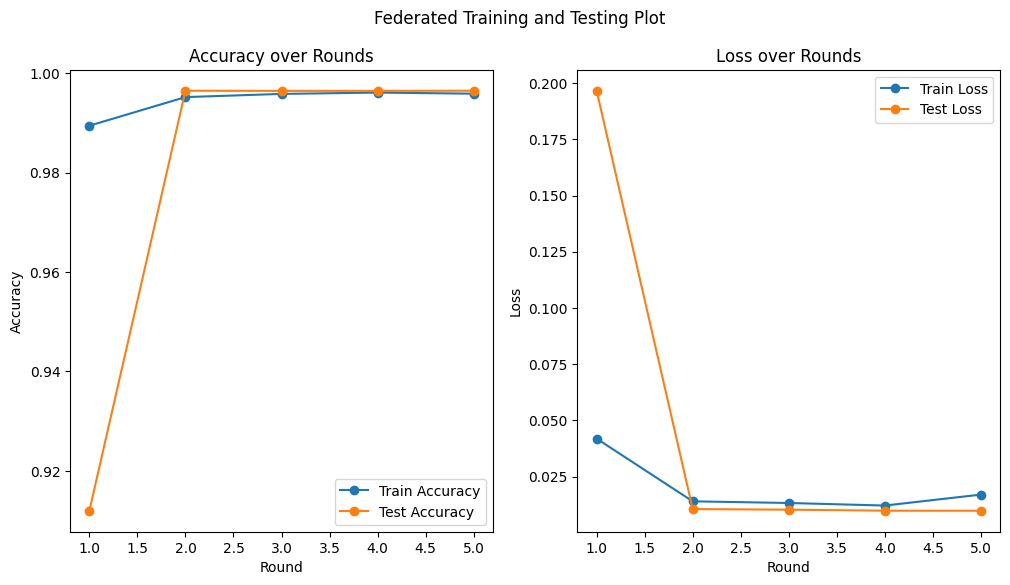

8802/8802 [==============================] - 27s 3ms/step


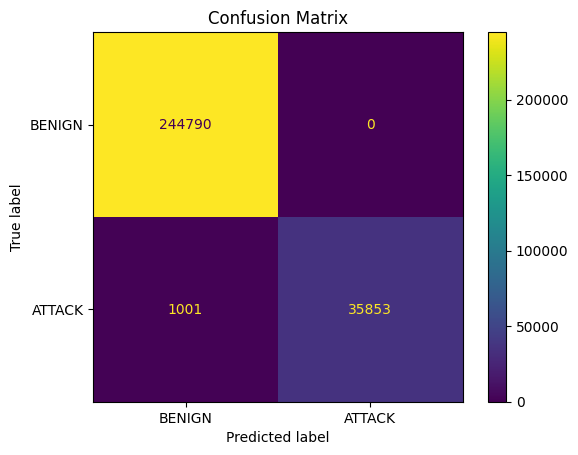

In [ ]:
import pandas as pd
import numpy as np
import collections
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/CICIoV2024/decimal.csv")

# Encode string labels into numerical values
label_mapping = {label: index for index, label in enumerate(df['label'].unique())}
df['label'] = df['label'].map(label_mapping)

# Split the data into train and test sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Create train data for five clients
def create_tf_dataset_for_client(client_data):
    data = client_data.iloc[:, 1:9].values.astype(np.float32)
    labels = client_data['label'].values.astype(np.int32)
    return tf.data.Dataset.from_tensor_slices((data, labels)).batch(32)

# Split the train_df into five parts for five clients
client_data_splits = np.array_split(train_df, 5)

# Create TF datasets for each client
train_data = [create_tf_dataset_for_client(client_data) for client_data in client_data_splits]

# Create a TF dataset for the test data
test_data = tf.data.Dataset.from_tensor_slices(
    (test_df.iloc[:, 1:9].values.astype(np.float32), test_df['label'].values.astype(np.int32))
).batch(32)

# Define the Keras model
def build_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Reshape((8, 1), input_shape=(8,)),
        tf.keras.layers.Conv1D(32, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(64, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(np.max(df['label']) + 1, activation='softmax')
    ])
    return model

# Wrap a Keras model for use with TFF.
def model_fn():
    keras_model = build_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=train_data[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

# Simulate a few rounds of training with the selected client devices.
trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.001)
)

state = trainer.initialize()

# Lists to store training and testing metrics
train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []

print("Training and Testing Results")

for round_num in range(5):
    # Training
    state, metrics = trainer.next(state, train_data)

    train_accuracy = metrics['client_work']['train']['sparse_categorical_accuracy']
    train_loss = metrics['client_work']['train']['loss']
    num_examples = metrics['client_work']['train']['num_examples']
    num_batches = metrics['client_work']['train']['num_batches']
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    print(f'Round {round_num+1}, Training accuracy: {train_accuracy:.4f}, Training loss: {train_loss:.4f}, Num examples: {num_examples}, Num batches: {num_batches}')

    # Testing
    eval_process = tff.learning.build_federated_evaluation(model_fn)
    model_weights = trainer.get_model_weights(state)
    test_metrics = eval_process(model_weights, [test_data])['eval']
    test_accuracy = test_metrics['sparse_categorical_accuracy']
    test_loss = test_metrics['loss']
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)
    #print(f"Round {round_num+1}, Testing accuracy: {test_accuracy:.4f}, Testing loss: {test_loss:.4f}, Num examples: {test_metrics['num_examples']}, Num batches: {test_metrics['num_batches']}")

rounds = range(1, 6)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(rounds, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(rounds, test_accuracies, marker='o', label='Test Accuracy')
plt.title('Accuracy over Rounds')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rounds, train_losses, marker='o', label='Train Loss')
plt.plot(rounds, test_losses, marker='o', label='Test Loss')
plt.title('Loss over Rounds')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()

plt.suptitle('Federated Training and Testing Plot')
plt.show()


# Confusion Matrix
keras_model = build_keras_model()
keras_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
keras_model.set_weights(model_weights.trainable)

y_true = np.concatenate([y for x, y in test_data], axis=0)
y_pred = np.argmax(keras_model.predict(test_data), axis=1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
disp.plot()
plt.title('Confusion Matrix')
plt.show()


**7 clients, 1D conv, Adam, lr=0.001**

Training and Testing Results
Round 1, Training accuracy: 0.9883, Training loss: 0.0451, Num examples: 1126575, Num batches: 35210


<ipython-input-1-393cbe6bd6ff>:90: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(model_fn)


Round 2, Training accuracy: 0.9951, Training loss: 0.0151, Num examples: 1126575, Num batches: 35210
Round 3, Training accuracy: 0.9959, Training loss: 0.0125, Num examples: 1126575, Num batches: 35210
Round 4, Training accuracy: 0.9961, Training loss: 0.0129, Num examples: 1126575, Num batches: 35210
Round 5, Training accuracy: 0.9954, Training loss: 0.0246, Num examples: 1126575, Num batches: 35210


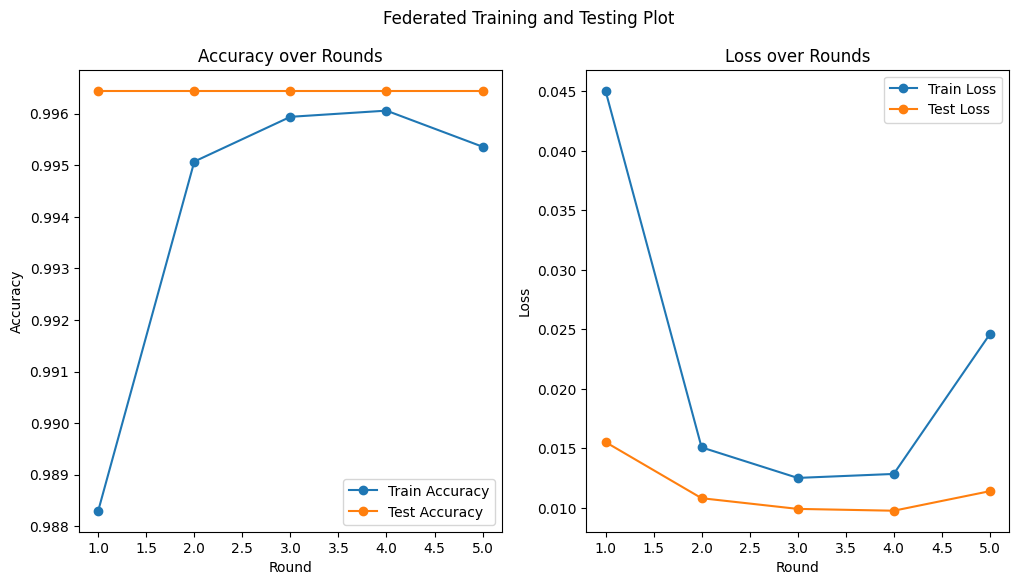

8802/8802 [==============================] - 17s 2ms/step


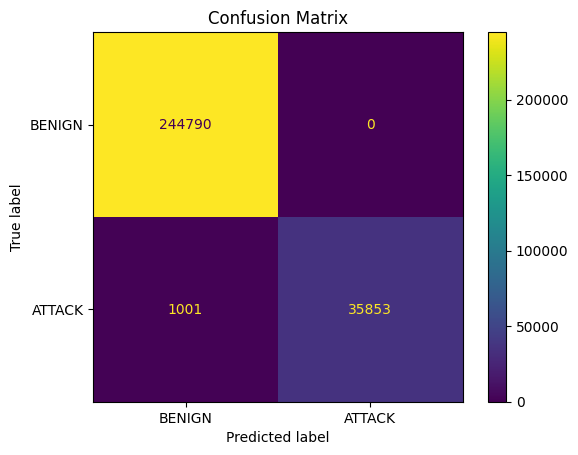

In [ ]:
import pandas as pd
import numpy as np
import collections
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/CICIoV2024/decimal.csv")

# Encode string labels into numerical values
label_mapping = {label: index for index, label in enumerate(df['label'].unique())}
df['label'] = df['label'].map(label_mapping)

# Split the data into train and test sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Create train data for seven clients
def create_tf_dataset_for_client(client_data):
    data = client_data.iloc[:, 1:9].values.astype(np.float32)
    labels = client_data['label'].values.astype(np.int32)
    return tf.data.Dataset.from_tensor_slices((data, labels)).batch(32)

# Split the train_df into seven parts
client_data_splits = np.array_split(train_df, 7)

# Create TF datasets for each client
train_data = [create_tf_dataset_for_client(client_data) for client_data in client_data_splits]

# Create a TF dataset for the test data
test_data = tf.data.Dataset.from_tensor_slices(
    (test_df.iloc[:, 1:9].values.astype(np.float32), test_df['label'].values.astype(np.int32))
).batch(32)

# Define the Keras model
def build_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Reshape((8, 1), input_shape=(8,)),
        tf.keras.layers.Conv1D(32, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(64, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(np.max(df['label']) + 1, activation='softmax')
    ])
    return model

# Wrap a Keras model for use with TFF.
def model_fn():
    keras_model = build_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=train_data[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

# Simulate a few rounds of training with the selected client devices.
trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.001)
)

state = trainer.initialize()

# Lists to store training and testing metrics
train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []

print("Training and Testing Results")

for round_num in range(5):
    # Training
    state, metrics = trainer.next(state, train_data)

    train_accuracy = metrics['client_work']['train']['sparse_categorical_accuracy']
    train_loss = metrics['client_work']['train']['loss']
    num_examples = metrics['client_work']['train']['num_examples']
    num_batches = metrics['client_work']['train']['num_batches']
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    print(f'Round {round_num+1}, Training accuracy: {train_accuracy:.4f}, Training loss: {train_loss:.4f}, Num examples: {num_examples}, Num batches: {num_batches}')

    # Testing
    eval_process = tff.learning.build_federated_evaluation(model_fn)
    model_weights = trainer.get_model_weights(state)
    test_metrics = eval_process(model_weights, [test_data])['eval']
    test_accuracy = test_metrics['sparse_categorical_accuracy']
    test_loss = test_metrics['loss']
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)
    #print(f"Round {round_num+1}, Testing accuracy: {test_accuracy:.4f}, Testing loss: {test_loss:.4f}, Num examples: {test_metrics['num_examples']}, Num batches: {test_metrics['num_batches']}")

rounds = range(1, 6)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(rounds, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(rounds, test_accuracies, marker='o', label='Test Accuracy')
plt.title('Accuracy over Rounds')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rounds, train_losses, marker='o', label='Train Loss')
plt.plot(rounds, test_losses, marker='o', label='Test Loss')
plt.title('Loss over Rounds')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()

plt.suptitle('Federated Training and Testing Plot')
plt.show()


# Confusion Matrix
keras_model = build_keras_model()
keras_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
keras_model.set_weights(model_weights.trainable)

y_true = np.concatenate([y for x, y in test_data], axis=0)
y_pred = np.argmax(keras_model.predict(test_data), axis=1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
disp.plot()
plt.title('Confusion Matrix')
plt.show()


# **Multi Classification using "category"**

**2 clients, 2D conv, SGD, lr=0.01, 80% train, 20% test**

In [ ]:
import pandas as pd
import numpy as np
import collections
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.model_selection import train_test_split

# Load the dataset
#df = pd.read_csv("decimal2.csv")
df = pd.read_csv("/content/drive/MyDrive/CICIoV2024/decimal.csv")

# Encode string labels into numerical values
label_mapping = {label: index for index, label in enumerate(df['category'].unique())}
df['category'] = df['category'].map(label_mapping)

# Split the data into train and test sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

## Create train data for two clients
def create_tf_dataset_for_client(client_data):
    data = client_data.iloc[:, 1:9].values.astype(np.float32)
    labels = client_data['category'].values.astype(np.int32)
    return tf.data.Dataset.from_tensor_slices((data, labels)).batch(32)

# Split the train_df into two parts for two clients
client_0_data, client_1_data = train_test_split(train_df, test_size=0.5, random_state=42)

# Create TF datasets for each client
train_data = [
    create_tf_dataset_for_client(client_0_data),
    create_tf_dataset_for_client(client_1_data)
]

# Create a TF dataset for the test data
test_data = tf.data.Dataset.from_tensor_slices(
    (test_df.iloc[:, 1:9].values.astype(np.float32), test_df['category'].values.astype(np.int32))
).batch(32)

# Wrap a Keras model for use with TFF.
def model_fn():
    keras_model = tf.keras.models.Sequential([
        tf.keras.layers.Reshape((2, 4, 1), input_shape=(8,)),
        tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(1, 1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(np.max(df['category']) + 1, activation='softmax')
    ])
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=train_data[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

# Simulate a few rounds of training with the selected client devices.
trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01)
)

state = trainer.initialize()

print("Training Results")
for round_num in range(5):
    state, metrics = trainer.next(state, train_data)

    train_accuracy = metrics['client_work']['train']['sparse_categorical_accuracy']
    train_loss = metrics['client_work']['train']['loss']
    num_examples = metrics['client_work']['train']['num_examples']
    num_batches = metrics['client_work']['train']['num_batches']
    print(f'Round {round_num+1}, Training accuracy: {train_accuracy:.4f}, Training loss: {train_loss:.4f}, Num examples: {num_examples}, Num batches: {num_batches}')

print("Testing Results")
for round_num in range(5):
    state, metrics = trainer.next(state, train_data)

    eval_process = tff.learning.build_federated_evaluation(model_fn)
    model_weights = trainer.get_model_weights(state)
    test_metrics = eval_process(model_weights, [test_data])['eval']
    print(f"Round {round_num+1}, Evaluation accuracy : {test_metrics['sparse_categorical_accuracy']}, Evaluation loss : {test_metrics['loss']},  Num examples: {test_metrics['num_examples']}, Num batches: {test_metrics['num_batches']}")


Training Results
Round 1, Training accuracy: 0.9898, Training loss: 0.0787, Num examples: 1126575, Num batches: 35206
Round 2, Training accuracy: 0.9991, Training loss: 0.0117, Num examples: 1126575, Num batches: 35206
Round 3, Training accuracy: 1.0000, Training loss: 0.0004, Num examples: 1126575, Num batches: 35206
Round 4, Training accuracy: 1.0000, Training loss: 0.0003, Num examples: 1126575, Num batches: 35206
Round 5, Training accuracy: 1.0000, Training loss: 0.0002, Num examples: 1126575, Num batches: 35206
Testing Results


<ipython-input-3-b4de2079695f>:78: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(model_fn)


Round 1, Evaluation accuracy : 0.9999929070472717, Evaluation loss : 0.00013285636669024825,  Num examples: 281644, Num batches: 8802
Round 2, Evaluation accuracy : 0.9999929070472717, Evaluation loss : 0.00012071723904227838,  Num examples: 281644, Num batches: 8802
Round 3, Evaluation accuracy : 0.9999929070472717, Evaluation loss : 0.00011076634109485894,  Num examples: 281644, Num batches: 8802
Round 4, Evaluation accuracy : 0.9999929070472717, Evaluation loss : 0.00010534015018492937,  Num examples: 281644, Num batches: 8802
Round 5, Evaluation accuracy : 0.9999929070472717, Evaluation loss : 9.989058162318543e-05,  Num examples: 281644, Num batches: 8802


**2 clients, 2D conv, SGD, lr=0.01, 70% train, 30% test**

In [ ]:
import pandas as pd
import numpy as np
import collections
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.model_selection import train_test_split

# Load the dataset
#df = pd.read_csv("decimal2.csv")
df = pd.read_csv("/content/drive/MyDrive/CICIoV2024/decimal.csv")

# Encode string labels into numerical values
label_mapping = {label: index for index, label in enumerate(df['category'].unique())}
df['category'] = df['category'].map(label_mapping)

# Split the data into train and test sets (70% train, 30% test)
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

## Create train data for two clients
def create_tf_dataset_for_client(client_data):
    data = client_data.iloc[:, 1:9].values.astype(np.float32)
    labels = client_data['category'].values.astype(np.int32)
    return tf.data.Dataset.from_tensor_slices((data, labels)).batch(32)

# Split the train_df into two parts for two clients
client_0_data, client_1_data = train_test_split(train_df, test_size=0.5, random_state=42)

# Create TF datasets for each client
train_data = [
    create_tf_dataset_for_client(client_0_data),
    create_tf_dataset_for_client(client_1_data)
]

# Create a TF dataset for the test data
test_data = tf.data.Dataset.from_tensor_slices(
    (test_df.iloc[:, 1:9].values.astype(np.float32), test_df['category'].values.astype(np.int32))
).batch(32)

# Wrap a Keras model for use with TFF.
def model_fn():
    keras_model = tf.keras.models.Sequential([
        tf.keras.layers.Reshape((2, 4, 1), input_shape=(8,)),
        tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(1, 1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(np.max(df['category']) + 1, activation='softmax')
    ])
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=train_data[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

# Simulate a few rounds of training with the selected client devices.
trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01)
)

state = trainer.initialize()

print("Training Results")
for round_num in range(5):
    state, metrics = trainer.next(state, train_data)

    train_accuracy = metrics['client_work']['train']['sparse_categorical_accuracy']
    train_loss = metrics['client_work']['train']['loss']
    num_examples = metrics['client_work']['train']['num_examples']
    num_batches = metrics['client_work']['train']['num_batches']
    print(f'Round {round_num+1}, Training accuracy: {train_accuracy:.4f}, Training loss: {train_loss:.4f}, Num examples: {num_examples}, Num batches: {num_batches}')

print("Testing Results")
for round_num in range(5):
    state, metrics = trainer.next(state, train_data)

    eval_process = tff.learning.build_federated_evaluation(model_fn)
    model_weights = trainer.get_model_weights(state)
    test_metrics = eval_process(model_weights, [test_data])['eval']
    print(f"Round {round_num+1}, Evaluation accuracy : {test_metrics['sparse_categorical_accuracy']}, Evaluation loss : {test_metrics['loss']},  Num examples: {test_metrics['num_examples']}, Num batches: {test_metrics['num_batches']}")


Training Results
Round 1, Training accuracy: 0.9901, Training loss: 0.0416, Num examples: 985753, Num batches: 30806
Round 2, Training accuracy: 0.9997, Training loss: 0.0031, Num examples: 985753, Num batches: 30806
Round 3, Training accuracy: 1.0000, Training loss: 0.0004, Num examples: 985753, Num batches: 30806
Round 4, Training accuracy: 1.0000, Training loss: 0.0003, Num examples: 985753, Num batches: 30806
Round 5, Training accuracy: 1.0000, Training loss: 0.0002, Num examples: 985753, Num batches: 30806
Testing Results


<ipython-input-4-dedc03c20dfa>:78: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(model_fn)


Round 1, Evaluation accuracy : 0.9999905228614807, Evaluation loss : 0.00015905954933259636,  Num examples: 422466, Num batches: 13203
Round 2, Evaluation accuracy : 0.9999905228614807, Evaluation loss : 0.00014555170491803437,  Num examples: 422466, Num batches: 13203
Round 3, Evaluation accuracy : 0.9999905228614807, Evaluation loss : 0.00013605639105662704,  Num examples: 422466, Num batches: 13203
Round 4, Evaluation accuracy : 0.9999905228614807, Evaluation loss : 0.00012923136819154024,  Num examples: 422466, Num batches: 13203
Round 5, Evaluation accuracy : 0.9999905228614807, Evaluation loss : 0.00012403454456944019,  Num examples: 422466, Num batches: 13203


**2 clients, 2D conv, Adam, lr=0.001**

In [ ]:
import pandas as pd
import numpy as np
import collections
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.model_selection import train_test_split

# Load the dataset
#df = pd.read_csv("decimal2.csv")
df = pd.read_csv("/content/drive/MyDrive/CICIoV2024/decimal.csv")

# Encode string labels into numerical values
label_mapping = {label: index for index, label in enumerate(df['category'].unique())}
df['category'] = df['category'].map(label_mapping)

# Split the data into train and test sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

## Create train data for two clients
def create_tf_dataset_for_client(client_data):
    data = client_data.iloc[:, 1:9].values.astype(np.float32)
    labels = client_data['category'].values.astype(np.int32)
    return tf.data.Dataset.from_tensor_slices((data, labels)).batch(32)

# Split the train_df into two parts for two clients
client_0_data, client_1_data = train_test_split(train_df, test_size=0.5, random_state=42)

# Create TF datasets for each client
train_data = [
    create_tf_dataset_for_client(client_0_data),
    create_tf_dataset_for_client(client_1_data)
]

# Create a TF dataset for the test data
test_data = tf.data.Dataset.from_tensor_slices(
    (test_df.iloc[:, 1:9].values.astype(np.float32), test_df['category'].values.astype(np.int32))
).batch(32)

# Wrap a Keras model for use with TFF.
def model_fn():
    keras_model = tf.keras.models.Sequential([
        tf.keras.layers.Reshape((2, 4, 1), input_shape=(8,)),
        tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(1, 1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(np.max(df['category']) + 1, activation='softmax')
    ])
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=train_data[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

# Simulate a few rounds of training with the selected client devices.
trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.001)
)

state = trainer.initialize()

print("Training Results")
for round_num in range(5):
    state, metrics = trainer.next(state, train_data)

    train_accuracy = metrics['client_work']['train']['sparse_categorical_accuracy']
    train_loss = metrics['client_work']['train']['loss']
    num_examples = metrics['client_work']['train']['num_examples']
    num_batches = metrics['client_work']['train']['num_batches']
    print(f'Round {round_num+1}, Training accuracy: {train_accuracy:.4f}, Training loss: {train_loss:.4f}, Num examples: {num_examples}, Num batches: {num_batches}')

print("Testing Results")
for round_num in range(5):
    state, metrics = trainer.next(state, train_data)

    eval_process = tff.learning.build_federated_evaluation(model_fn)
    model_weights = trainer.get_model_weights(state)
    test_metrics = eval_process(model_weights, [test_data])['eval']
    print(f"Round {round_num+1}, Evaluation accuracy : {test_metrics['sparse_categorical_accuracy']}, Evaluation loss : {test_metrics['loss']},  Num examples: {test_metrics['num_examples']}, Num batches: {test_metrics['num_batches']}")


Training Results
Round 1, Training accuracy: 0.9687, Training loss: 0.4880, Num examples: 1126575, Num batches: 35206
Round 2, Training accuracy: 0.9726, Training loss: 0.4412, Num examples: 1126575, Num batches: 35206
Round 3, Training accuracy: 0.9751, Training loss: 0.4012, Num examples: 1126575, Num batches: 35206
Round 4, Training accuracy: 0.9751, Training loss: 0.4008, Num examples: 1126575, Num batches: 35206
Round 5, Training accuracy: 0.9751, Training loss: 0.4008, Num examples: 1126575, Num batches: 35206
Testing Results


<ipython-input-1-43f1e5f71a96>:78: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(model_fn)


Round 1, Evaluation accuracy : 0.9753447771072388, Evaluation loss : 0.3973800539970398,  Num examples: 281644, Num batches: 8802
Round 2, Evaluation accuracy : 0.9753447771072388, Evaluation loss : 0.3973800539970398,  Num examples: 281644, Num batches: 8802
Round 3, Evaluation accuracy : 0.9753447771072388, Evaluation loss : 0.3973800539970398,  Num examples: 281644, Num batches: 8802
Round 4, Evaluation accuracy : 0.9753447771072388, Evaluation loss : 0.3973800539970398,  Num examples: 281644, Num batches: 8802
Round 5, Evaluation accuracy : 0.9753447771072388, Evaluation loss : 0.3973800539970398,  Num examples: 281644, Num batches: 8802


**2 clients, 1D conv, Adam, lr=0.001**

Training and Testing Results
Round 1, Training accuracy: 0.9932, Training loss: 0.0226, Num examples: 1126575, Num batches: 35206


<ipython-input-14-357a8b71e498>:160: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(model_fn)


Round 1, Testing accuracy: 0.9922, Testing loss: 0.0342, Num examples: 281644, Num batches: 8802
Round 2, Training accuracy: 0.9959, Training loss: 0.0148, Num examples: 1126575, Num batches: 35206
Round 2, Testing accuracy: 0.9953, Testing loss: 0.0280, Num examples: 281644, Num batches: 8802
Round 3, Training accuracy: 0.9946, Training loss: 0.0374, Num examples: 1126575, Num batches: 35206
Round 3, Testing accuracy: 0.9928, Testing loss: 0.0601, Num examples: 281644, Num batches: 8802
Round 4, Training accuracy: 0.9931, Training loss: 0.0618, Num examples: 1126575, Num batches: 35206
Round 4, Testing accuracy: 0.9928, Testing loss: 0.0681, Num examples: 281644, Num batches: 8802
Round 5, Training accuracy: 0.9927, Training loss: 0.0692, Num examples: 1126575, Num batches: 35206
Round 5, Testing accuracy: 0.9928, Testing loss: 0.0684, Num examples: 281644, Num batches: 8802


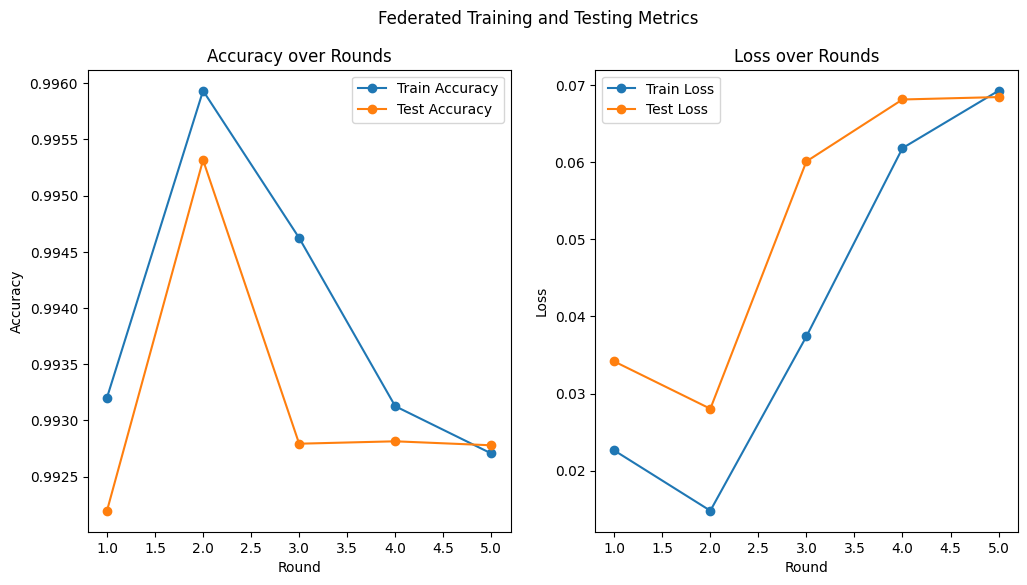

8802/8802 [==============================] - 18s 2ms/step


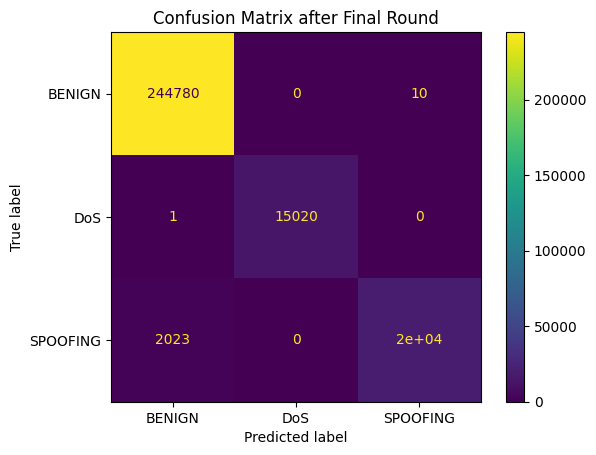

In [ ]:
import pandas as pd
import numpy as np
import collections
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/CICIoV2024/decimal.csv")

# Encode string labels into numerical values
label_mapping = {label: index for index, label in enumerate(df['category'].unique())}
df['category'] = df['category'].map(label_mapping)

# Split the data into train and test sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

## Create train data for two clients
def create_tf_dataset_for_client(client_data):
    data = client_data.iloc[:, 1:9].values.astype(np.float32)
    labels = client_data['category'].values.astype(np.int32)
    return tf.data.Dataset.from_tensor_slices((data, labels)).batch(32)

# Split the train_df into two parts for two clients
client_0_data, client_1_data = train_test_split(train_df, test_size=0.5, random_state=42)

# Create TF datasets for each client
train_data = [
    create_tf_dataset_for_client(client_0_data),
    create_tf_dataset_for_client(client_1_data)
]

# Create a TF dataset for the test data
test_data = tf.data.Dataset.from_tensor_slices(
    (test_df.iloc[:, 1:9].values.astype(np.float32), test_df['category'].values.astype(np.int32))
).batch(32)

# Define the Keras model
def build_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Reshape((8, 1), input_shape=(8,)),
        tf.keras.layers.Conv1D(32, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(64, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(np.max(df['category']) + 1, activation='softmax')
    ])
    return model

# Wrap a Keras model for use with TFF.
def model_fn():
    keras_model = build_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=train_data[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

# Simulate a few rounds of training with the selected client devices.
trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.001)
)

state = trainer.initialize()

# Lists to store training and testing metrics
train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []

print("Training and Testing Results")

for round_num in range(5):
    # Training
    state, metrics = trainer.next(state, train_data)

    train_accuracy = metrics['client_work']['train']['sparse_categorical_accuracy']
    train_loss = metrics['client_work']['train']['loss']
    num_examples = metrics['client_work']['train']['num_examples']
    num_batches = metrics['client_work']['train']['num_batches']
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    print(f'Round {round_num+1}, Training accuracy: {train_accuracy:.4f}, Training loss: {train_loss:.4f}, Num examples: {num_examples}, Num batches: {num_batches}')

    # Testing
    eval_process = tff.learning.build_federated_evaluation(model_fn)
    model_weights = trainer.get_model_weights(state)
    test_metrics = eval_process(model_weights, [test_data])['eval']
    test_accuracy = test_metrics['sparse_categorical_accuracy']
    test_loss = test_metrics['loss']
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)
    print(f"Round {round_num+1}, Testing accuracy: {test_accuracy:.4f}, Testing loss: {test_loss:.4f}, Num examples: {test_metrics['num_examples']}, Num batches: {test_metrics['num_batches']}")

rounds = range(1, 6)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(rounds, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(rounds, test_accuracies, marker='o', label='Test Accuracy')
plt.title('Accuracy over Rounds')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rounds, train_losses, marker='o', label='Train Loss')
plt.plot(rounds, test_losses, marker='o', label='Test Loss')
plt.title('Loss over Rounds')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()

plt.suptitle('Federated Training and Testing Metrics')
plt.show()


# Confusion Matrix
keras_model = build_keras_model()
keras_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
keras_model.set_weights(model_weights.trainable)

y_true = np.concatenate([y for x, y in test_data], axis=0)
y_pred = np.argmax(keras_model.predict(test_data), axis=1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
disp.plot()
plt.title('Confusion Matrix')
plt.show()


**5 clients, 1D conv, Adam, lr=0.001**

Training and Testing Results
Round 1, Training accuracy: 0.9889, Training loss: 0.0570, Num examples: 1126575, Num batches: 35210


<ipython-input-6-9503cba33d8a>:90: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(model_fn)


Round 2, Training accuracy: 0.9954, Training loss: 0.0138, Num examples: 1126575, Num batches: 35210
Round 3, Training accuracy: 0.9958, Training loss: 0.0152, Num examples: 1126575, Num batches: 35210
Round 4, Training accuracy: 0.9955, Training loss: 0.0227, Num examples: 1126575, Num batches: 35210
Round 5, Training accuracy: 0.9954, Training loss: 0.0240, Num examples: 1126575, Num batches: 35210


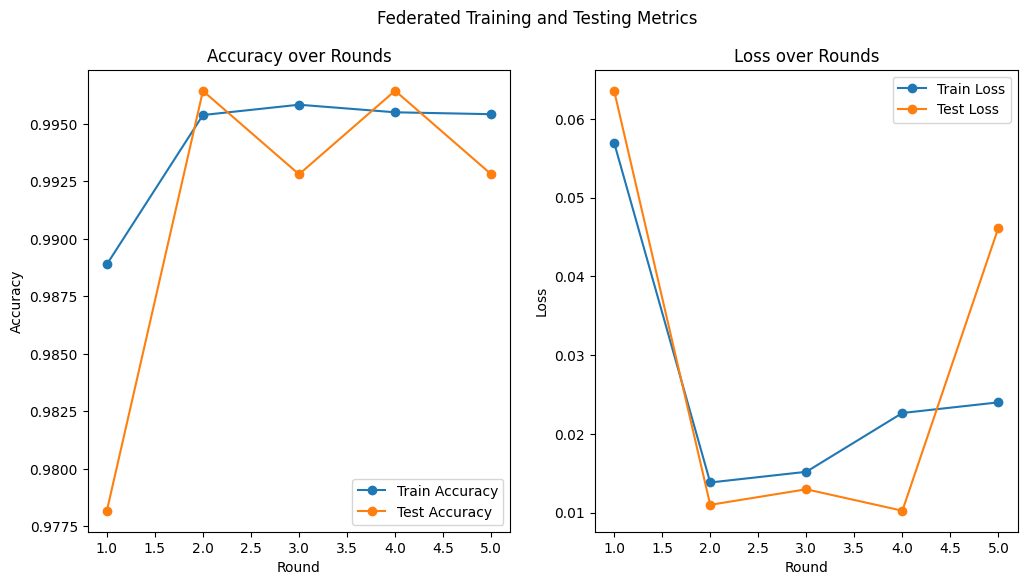

8802/8802 [==============================] - 18s 2ms/step


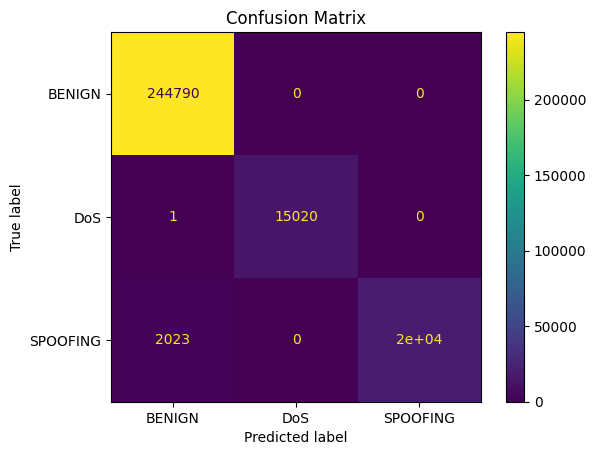

In [ ]:
import pandas as pd
import numpy as np
import collections
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/CICIoV2024/decimal.csv")

# Encode string labels into numerical values
label_mapping = {label: index for index, label in enumerate(df['category'].unique())}
df['category'] = df['category'].map(label_mapping)

# Split the data into train and test sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Create train data for five clients
def create_tf_dataset_for_client(client_data):
    data = client_data.iloc[:, 1:9].values.astype(np.float32)
    labels = client_data['category'].values.astype(np.int32)
    return tf.data.Dataset.from_tensor_slices((data, labels)).batch(32)

# Split the train_df into five parts for five clients
client_data_splits = np.array_split(train_df, 5)

# Create TF datasets for each client
train_data = [create_tf_dataset_for_client(client_data) for client_data in client_data_splits]

# Create a TF dataset for the test data
test_data = tf.data.Dataset.from_tensor_slices(
    (test_df.iloc[:, 1:9].values.astype(np.float32), test_df['category'].values.astype(np.int32))
).batch(32)

# Define the Keras model
def build_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Reshape((8, 1), input_shape=(8,)),
        tf.keras.layers.Conv1D(32, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(64, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(np.max(df['category']) + 1, activation='softmax')
    ])
    return model

# Wrap a Keras model for use with TFF.
def model_fn():
    keras_model = build_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=train_data[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

# Simulate a few rounds of training with the selected client devices.
trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.001)
)

state = trainer.initialize()

# Lists to store training and testing metrics
train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []

print("Training and Testing Results")

for round_num in range(5):
    # Training
    state, metrics = trainer.next(state, train_data)

    train_accuracy = metrics['client_work']['train']['sparse_categorical_accuracy']
    train_loss = metrics['client_work']['train']['loss']
    num_examples = metrics['client_work']['train']['num_examples']
    num_batches = metrics['client_work']['train']['num_batches']
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    print(f'Round {round_num+1}, Training accuracy: {train_accuracy:.4f}, Training loss: {train_loss:.4f}, Num examples: {num_examples}, Num batches: {num_batches}')

    # Testing
    eval_process = tff.learning.build_federated_evaluation(model_fn)
    model_weights = trainer.get_model_weights(state)
    test_metrics = eval_process(model_weights, [test_data])['eval']
    test_accuracy = test_metrics['sparse_categorical_accuracy']
    test_loss = test_metrics['loss']
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)
    #print(f"Round {round_num+1}, Testing accuracy: {test_accuracy:.4f}, Testing loss: {test_loss:.4f}, Num examples: {test_metrics['num_examples']}, Num batches: {test_metrics['num_batches']}")

rounds = range(1, 6)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(rounds, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(rounds, test_accuracies, marker='o', label='Test Accuracy')
plt.title('Accuracy over Rounds')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rounds, train_losses, marker='o', label='Train Loss')
plt.plot(rounds, test_losses, marker='o', label='Test Loss')
plt.title('Loss over Rounds')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()

plt.suptitle('Federated Training and Testing Metrics')
plt.show()


# Confusion Matrix
keras_model = build_keras_model()
keras_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
keras_model.set_weights(model_weights.trainable)

y_true = np.concatenate([y for x, y in test_data], axis=0)
y_pred = np.argmax(keras_model.predict(test_data), axis=1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
disp.plot()
plt.title('Confusion Matrix')
plt.show()


**7 clients, 1D conv, Adam, lr=0.001**

Training and Testing Results
Round 1, Training accuracy: 0.9874, Training loss: 0.0448, Num examples: 1126575, Num batches: 35210


<ipython-input-2-005e2710a5ca>:90: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(model_fn)


Round 2, Training accuracy: 0.9947, Training loss: 0.0169, Num examples: 1126575, Num batches: 35210
Round 3, Training accuracy: 0.9959, Training loss: 0.0129, Num examples: 1126575, Num batches: 35210
Round 4, Training accuracy: 0.9959, Training loss: 0.0149, Num examples: 1126575, Num batches: 35210
Round 5, Training accuracy: 0.9948, Training loss: 0.0349, Num examples: 1126575, Num batches: 35210


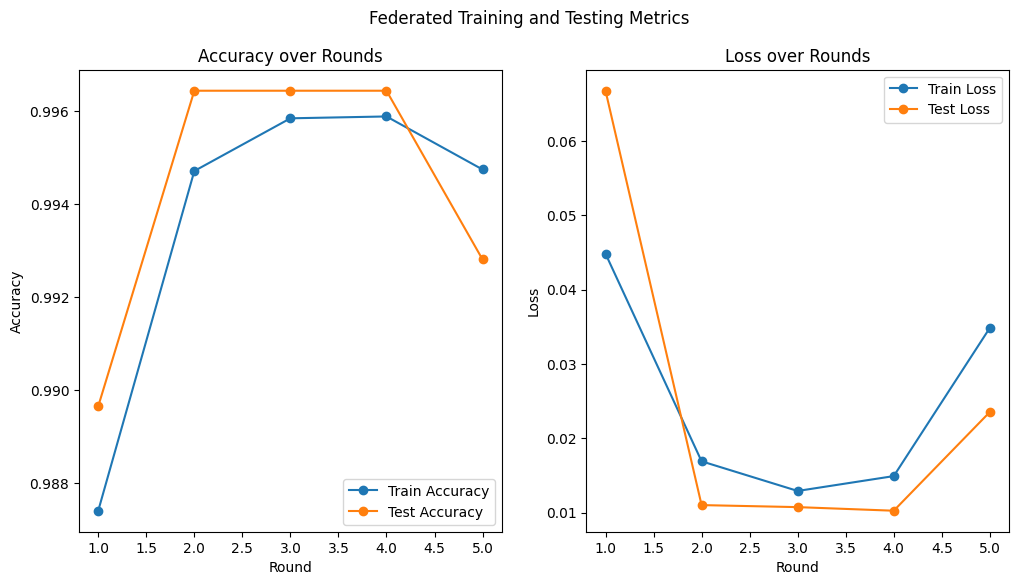

8802/8802 [==============================] - 17s 2ms/step


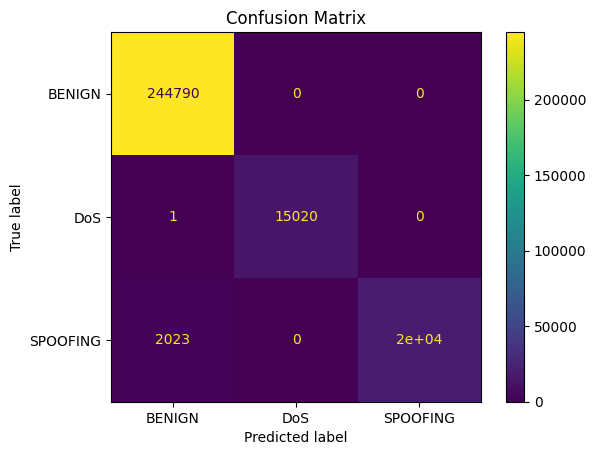

In [ ]:
import pandas as pd
import numpy as np
import collections
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/CICIoV2024/decimal.csv")

# Encode string labels into numerical values
label_mapping = {label: index for index, label in enumerate(df['category'].unique())}
df['category'] = df['category'].map(label_mapping)

# Split the data into train and test sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Create train data for 7 clients
def create_tf_dataset_for_client(client_data):
    data = client_data.iloc[:, 1:9].values.astype(np.float32)
    labels = client_data['category'].values.astype(np.int32)
    return tf.data.Dataset.from_tensor_slices((data, labels)).batch(32)

# Split the train_df into 7 parts
client_data_splits = np.array_split(train_df, 7)

# Create TF datasets for each client
train_data = [create_tf_dataset_for_client(client_data) for client_data in client_data_splits]

# Create a TF dataset for the test data
test_data = tf.data.Dataset.from_tensor_slices(
    (test_df.iloc[:, 1:9].values.astype(np.float32), test_df['category'].values.astype(np.int32))
).batch(32)

# Define the Keras model
def build_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Reshape((8, 1), input_shape=(8,)),
        tf.keras.layers.Conv1D(32, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(64, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(np.max(df['category']) + 1, activation='softmax')
    ])
    return model

# Wrap a Keras model for use with TFF.
def model_fn():
    keras_model = build_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=train_data[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

# Simulate a few rounds of training with the selected client devices.
trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.001)
)

state = trainer.initialize()

# Lists to store training and testing metrics
train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []

print("Training and Testing Results")

for round_num in range(5):
    # Training
    state, metrics = trainer.next(state, train_data)

    train_accuracy = metrics['client_work']['train']['sparse_categorical_accuracy']
    train_loss = metrics['client_work']['train']['loss']
    num_examples = metrics['client_work']['train']['num_examples']
    num_batches = metrics['client_work']['train']['num_batches']
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    print(f'Round {round_num+1}, Training accuracy: {train_accuracy:.4f}, Training loss: {train_loss:.4f}, Num examples: {num_examples}, Num batches: {num_batches}')

    # Testing
    eval_process = tff.learning.build_federated_evaluation(model_fn)
    model_weights = trainer.get_model_weights(state)
    test_metrics = eval_process(model_weights, [test_data])['eval']
    test_accuracy = test_metrics['sparse_categorical_accuracy']
    test_loss = test_metrics['loss']
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)
    #print(f"Round {round_num+1}, Testing accuracy: {test_accuracy:.4f}, Testing loss: {test_loss:.4f}, Num examples: {test_metrics['num_examples']}, Num batches: {test_metrics['num_batches']}")

rounds = range(1, 6)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(rounds, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(rounds, test_accuracies, marker='o', label='Test Accuracy')
plt.title('Accuracy over Rounds')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rounds, train_losses, marker='o', label='Train Loss')
plt.plot(rounds, test_losses, marker='o', label='Test Loss')
plt.title('Loss over Rounds')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()

plt.suptitle('Federated Training and Testing Metrics')
plt.show()


# Confusion Matrix
keras_model = build_keras_model()
keras_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
keras_model.set_weights(model_weights.trainable)

y_true = np.concatenate([y for x, y in test_data], axis=0)
y_pred = np.argmax(keras_model.predict(test_data), axis=1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
disp.plot()
plt.title('Confusion Matrix')
plt.show()


# **Multi Classification using "specific_class"**

**2 clients, 2D conv, SGD, lr=0.01**

In [ ]:
import pandas as pd
import numpy as np
import collections
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.model_selection import train_test_split

# Load the dataset
#df = pd.read_csv("decimal2.csv")
df = pd.read_csv("/content/drive/MyDrive/CICIoV2024/decimal.csv")

# Encode string labels into numerical values
label_mapping = {label: index for index, label in enumerate(df['specific_class'].unique())}
df['specific_class'] = df['specific_class'].map(label_mapping)

# Split the data into train and test sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Create train data for two clients
def create_tf_dataset_for_client(client_data):
    data = client_data.iloc[:, 1:9].values.astype(np.float32)
    labels = client_data['specific_class'].values.astype(np.int32)
    return tf.data.Dataset.from_tensor_slices((data, labels)).batch(32)

# Split the train_df into two parts for two clients
client_0_data, client_1_data = train_test_split(train_df, test_size=0.5, random_state=42)

# Create TF datasets for each client
train_data = [
    create_tf_dataset_for_client(client_0_data),
    create_tf_dataset_for_client(client_1_data)
]

# Create a TF dataset for the test data
test_data = tf.data.Dataset.from_tensor_slices(
    (test_df.iloc[:, 1:9].values.astype(np.float32), test_df['specific_class'].values.astype(np.int32))
).batch(32)

# Wrap a Keras model for use with TFF.
def model_fn():
    keras_model = tf.keras.models.Sequential([
        tf.keras.layers.Reshape((2, 4, 1), input_shape=(8,)),
        tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(1, 1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(np.max(df['specific_class']) + 1, activation='softmax')
    ])
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=train_data[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

# Simulate a few rounds of training with the selected client devices.
trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01)
)

state = trainer.initialize()

print("Training Results")
for round_num in range(5):
    state, metrics = trainer.next(state, train_data)

    train_accuracy = metrics['client_work']['train']['sparse_categorical_accuracy']
    train_loss = metrics['client_work']['train']['loss']
    num_examples = metrics['client_work']['train']['num_examples']
    num_batches = metrics['client_work']['train']['num_batches']
    print(f'Round {round_num+1}, Training accuracy: {train_accuracy:.4f}, Training loss: {train_loss:.4f}, Num examples: {num_examples}, Num batches: {num_batches}')

print("Testing Results")
for round_num in range(5):
    state, metrics = trainer.next(state, train_data)

    eval_process = tff.learning.build_federated_evaluation(model_fn)
    model_weights = trainer.get_model_weights(state)
    test_metrics = eval_process(model_weights, [test_data])['eval']
    print(f"Round {round_num+1}, Evaluation accuracy : {test_metrics['sparse_categorical_accuracy']}, Evaluation loss : {test_metrics['loss']},  Num examples: {test_metrics['num_examples']}, Num batches: {test_metrics['num_batches']}")


Training Results
Round 1, Training accuracy: 0.9497, Training loss: 0.6783, Num examples: 1126575, Num batches: 35206
Round 2, Training accuracy: 0.9710, Training loss: 0.4125, Num examples: 1126575, Num batches: 35206
Round 3, Training accuracy: 0.9715, Training loss: 0.4070, Num examples: 1126575, Num batches: 35206
Round 4, Training accuracy: 0.9716, Training loss: 0.4060, Num examples: 1126575, Num batches: 35206
Round 5, Training accuracy: 0.9716, Training loss: 0.4058, Num examples: 1126575, Num batches: 35206
Testing Results


<ipython-input-3-8e38e0570979>:78: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(model_fn)


Round 1, Evaluation accuracy : 0.9718261361122131, Evaluation loss : 0.40225622057914734,  Num examples: 281644, Num batches: 8802
Round 2, Evaluation accuracy : 0.9718261361122131, Evaluation loss : 0.4022362232208252,  Num examples: 281644, Num batches: 8802
Round 3, Evaluation accuracy : 0.9718261361122131, Evaluation loss : 0.4022226631641388,  Num examples: 281644, Num batches: 8802
Round 4, Evaluation accuracy : 0.9718261361122131, Evaluation loss : 0.40221166610717773,  Num examples: 281644, Num batches: 8802
Round 5, Evaluation accuracy : 0.9718261361122131, Evaluation loss : 0.4022051990032196,  Num examples: 281644, Num batches: 8802


**2 clients, 1D conv, Adam, lr=0.001**

Training and Testing Results
Round 1, Training accuracy: 0.9901, Training loss: 0.0308, Num examples: 1126575, Num batches: 35206


<ipython-input-7-be4cac0abbc2>:93: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(model_fn)


Round 2, Training accuracy: 0.9906, Training loss: 0.0494, Num examples: 1126575, Num batches: 35206
Round 3, Training accuracy: 0.9897, Training loss: 0.0653, Num examples: 1126575, Num batches: 35206
Round 4, Training accuracy: 0.9865, Training loss: 0.1168, Num examples: 1126575, Num batches: 35206
Round 5, Training accuracy: 0.9809, Training loss: 0.2073, Num examples: 1126575, Num batches: 35206


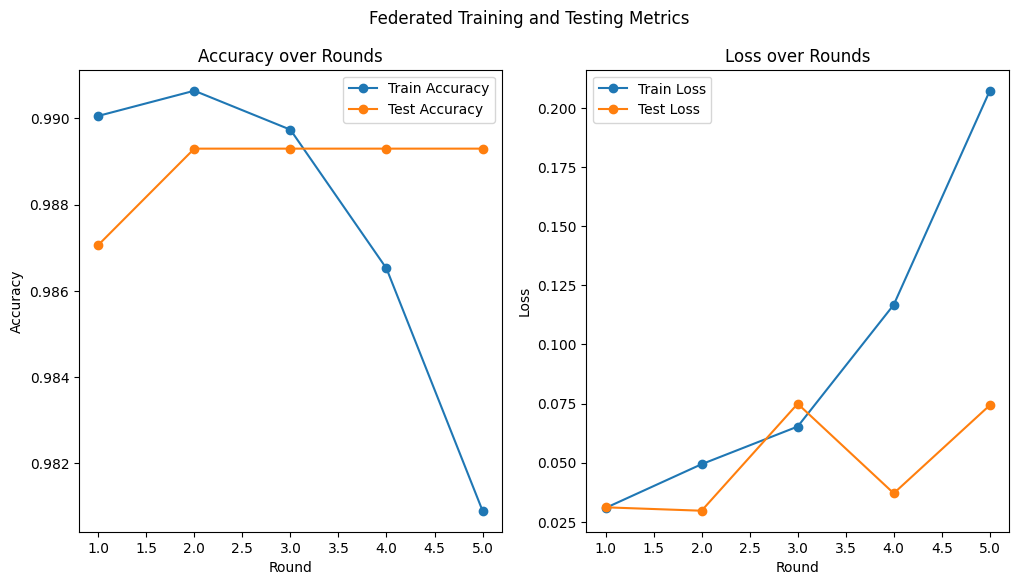

8802/8802 [==============================] - 20s 2ms/step


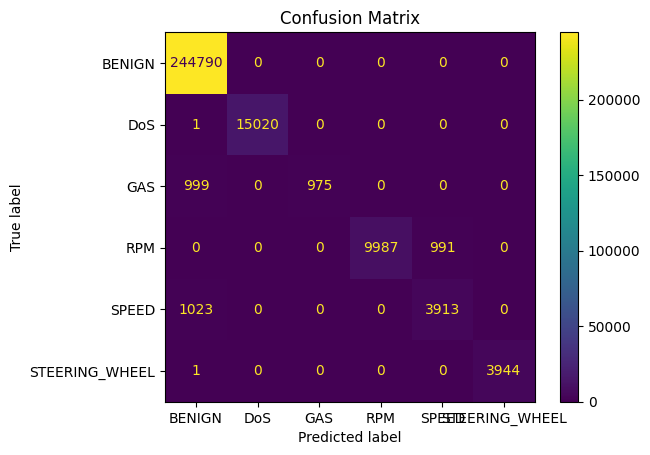

In [ ]:
import pandas as pd
import numpy as np
import collections
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/CICIoV2024/decimal.csv")

# Encode string labels into numerical values
label_mapping = {label: index for index, label in enumerate(df['specific_class'].unique())}
df['specific_class'] = df['specific_class'].map(label_mapping)

# Split the data into train and test sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

## Create train data for two clients
def create_tf_dataset_for_client(client_data):
    data = client_data.iloc[:, 1:9].values.astype(np.float32)
    labels = client_data['specific_class'].values.astype(np.int32)
    return tf.data.Dataset.from_tensor_slices((data, labels)).batch(32)

# Split the train_df into two parts for two clients
client_0_data, client_1_data = train_test_split(train_df, test_size=0.5, random_state=42)

# Create TF datasets for each client
train_data = [
    create_tf_dataset_for_client(client_0_data),
    create_tf_dataset_for_client(client_1_data)
]

# Create a TF dataset for the test data
test_data = tf.data.Dataset.from_tensor_slices(
    (test_df.iloc[:, 1:9].values.astype(np.float32), test_df['specific_class'].values.astype(np.int32))
).batch(32)

# Define the Keras model
def build_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Reshape((8, 1), input_shape=(8,)),
        tf.keras.layers.Conv1D(32, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(64, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(np.max(df['specific_class']) + 1, activation='softmax')
    ])
    return model

# Wrap a Keras model for use with TFF.
def model_fn():
    keras_model = build_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=train_data[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

# Simulate a few rounds of training with the selected client devices.
trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.001)
)

state = trainer.initialize()

# Lists to store training and testing metrics
train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []

print("Training and Testing Results")

for round_num in range(5):
    # Training
    state, metrics = trainer.next(state, train_data)

    train_accuracy = metrics['client_work']['train']['sparse_categorical_accuracy']
    train_loss = metrics['client_work']['train']['loss']
    num_examples = metrics['client_work']['train']['num_examples']
    num_batches = metrics['client_work']['train']['num_batches']
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    print(f'Round {round_num+1}, Training accuracy: {train_accuracy:.4f}, Training loss: {train_loss:.4f}, Num examples: {num_examples}, Num batches: {num_batches}')

    # Testing
    eval_process = tff.learning.build_federated_evaluation(model_fn)
    model_weights = trainer.get_model_weights(state)
    test_metrics = eval_process(model_weights, [test_data])['eval']
    test_accuracy = test_metrics['sparse_categorical_accuracy']
    test_loss = test_metrics['loss']
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)
    #print(f"Round {round_num+1}, Testing accuracy: {test_accuracy:.4f}, Testing loss: {test_loss:.4f}, Num examples: {test_metrics['num_examples']}, Num batches: {test_metrics['num_batches']}")

rounds = range(1, 6)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(rounds, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(rounds, test_accuracies, marker='o', label='Test Accuracy')
plt.title('Accuracy over Rounds')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rounds, train_losses, marker='o', label='Train Loss')
plt.plot(rounds, test_losses, marker='o', label='Test Loss')
plt.title('Loss over Rounds')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()

plt.suptitle('Federated Training and Testing Metrics')
plt.show()


# Confusion Matrix
keras_model = build_keras_model()
keras_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
keras_model.set_weights(model_weights.trainable)

y_true = np.concatenate([y for x, y in test_data], axis=0)
y_pred = np.argmax(keras_model.predict(test_data), axis=1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
disp.plot()
plt.title('Confusion Matrix')
plt.show()


**5 clients, 1D conv, Adam, lr=0.001**

Training and Testing Results
Round 1, Training accuracy: 0.9749, Training loss: 0.2402, Num examples: 1126575, Num batches: 35210


<ipython-input-8-b03a5e3d6717>:90: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(model_fn)


Round 2, Training accuracy: 0.9915, Training loss: 0.0240, Num examples: 1126575, Num batches: 35210
Round 3, Training accuracy: 0.9924, Training loss: 0.0188, Num examples: 1126575, Num batches: 35210
Round 4, Training accuracy: 0.9918, Training loss: 0.0300, Num examples: 1126575, Num batches: 35210
Round 5, Training accuracy: 0.9916, Training loss: 0.0337, Num examples: 1126575, Num batches: 35210


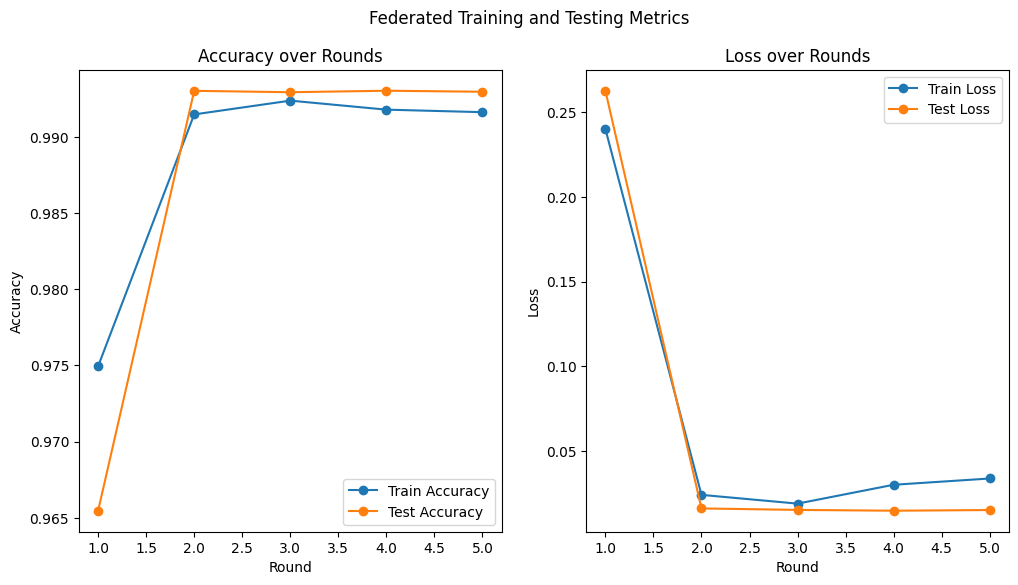

8802/8802 [==============================] - 17s 2ms/step


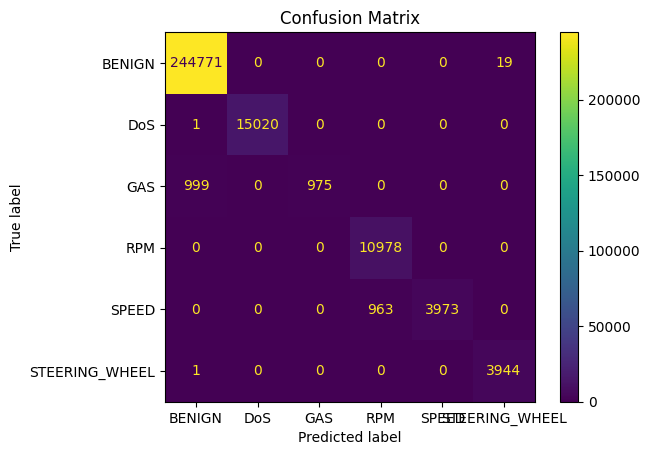

In [ ]:
import pandas as pd
import numpy as np
import collections
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/CICIoV2024/decimal.csv")

# Encode string labels into numerical values
label_mapping = {label: index for index, label in enumerate(df['specific_class'].unique())}
df['specific_class'] = df['specific_class'].map(label_mapping)

# Split the data into train and test sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Create train data for five clients
def create_tf_dataset_for_client(client_data):
    data = client_data.iloc[:, 1:9].values.astype(np.float32)
    labels = client_data['specific_class'].values.astype(np.int32)
    return tf.data.Dataset.from_tensor_slices((data, labels)).batch(32)

# Split the train_df into five parts for five clients
client_data_splits = np.array_split(train_df, 5)

# Create TF datasets for each client
train_data = [create_tf_dataset_for_client(client_data) for client_data in client_data_splits]

# Create a TF dataset for the test data
test_data = tf.data.Dataset.from_tensor_slices(
    (test_df.iloc[:, 1:9].values.astype(np.float32), test_df['specific_class'].values.astype(np.int32))
).batch(32)

# Define the Keras model
def build_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Reshape((8, 1), input_shape=(8,)),
        tf.keras.layers.Conv1D(32, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(64, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(np.max(df['specific_class']) + 1, activation='softmax')
    ])
    return model

# Wrap a Keras model for use with TFF.
def model_fn():
    keras_model = build_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=train_data[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

# Simulate a few rounds of training with the selected client devices.
trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.001)
)

state = trainer.initialize()

# Lists to store training and testing metrics
train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []

print("Training and Testing Results")

for round_num in range(5):
    # Training
    state, metrics = trainer.next(state, train_data)

    train_accuracy = metrics['client_work']['train']['sparse_categorical_accuracy']
    train_loss = metrics['client_work']['train']['loss']
    num_examples = metrics['client_work']['train']['num_examples']
    num_batches = metrics['client_work']['train']['num_batches']
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    print(f'Round {round_num+1}, Training accuracy: {train_accuracy:.4f}, Training loss: {train_loss:.4f}, Num examples: {num_examples}, Num batches: {num_batches}')

    # Testing
    eval_process = tff.learning.build_federated_evaluation(model_fn)
    model_weights = trainer.get_model_weights(state)
    test_metrics = eval_process(model_weights, [test_data])['eval']
    test_accuracy = test_metrics['sparse_categorical_accuracy']
    test_loss = test_metrics['loss']
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)
    #print(f"Round {round_num+1}, Testing accuracy: {test_accuracy:.4f}, Testing loss: {test_loss:.4f}, Num examples: {test_metrics['num_examples']}, Num batches: {test_metrics['num_batches']}")

rounds = range(1, 6)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(rounds, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(rounds, test_accuracies, marker='o', label='Test Accuracy')
plt.title('Accuracy over Rounds')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rounds, train_losses, marker='o', label='Train Loss')
plt.plot(rounds, test_losses, marker='o', label='Test Loss')
plt.title('Loss over Rounds')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()

plt.suptitle('Federated Training and Testing Metrics')
plt.show()


# Confusion Matrix
keras_model = build_keras_model()
keras_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
keras_model.set_weights(model_weights.trainable)

y_true = np.concatenate([y for x, y in test_data], axis=0)
y_pred = np.argmax(keras_model.predict(test_data), axis=1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
disp.plot()
plt.title('Confusion Matrix')
plt.show()


**7 clients, 1D conv, Adam, lr=0.001**

Training and Testing Results
Round 1, Training accuracy: 0.9721, Training loss: 0.2586, Num examples: 1126575, Num batches: 35210


<ipython-input-9-d4af632ea4b8>:90: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(model_fn)


Round 2, Training accuracy: 0.9795, Training loss: 0.2170, Num examples: 1126575, Num batches: 35210
Round 3, Training accuracy: 0.9782, Training loss: 0.2476, Num examples: 1126575, Num batches: 35210
Round 4, Training accuracy: 0.9780, Training loss: 0.2527, Num examples: 1126575, Num batches: 35210
Round 5, Training accuracy: 0.9742, Training loss: 0.3147, Num examples: 1126575, Num batches: 35210


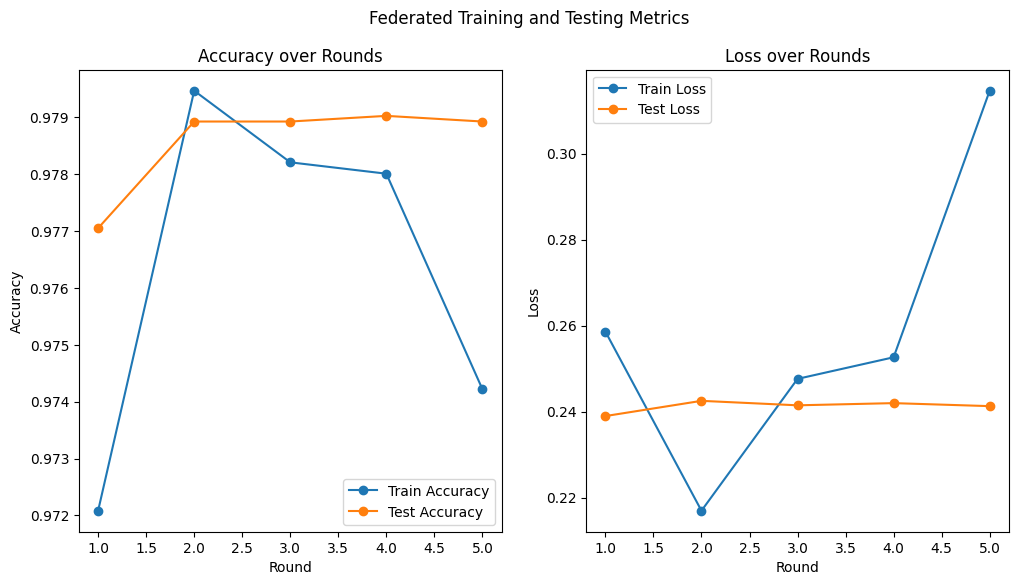

8802/8802 [==============================] - 17s 2ms/step


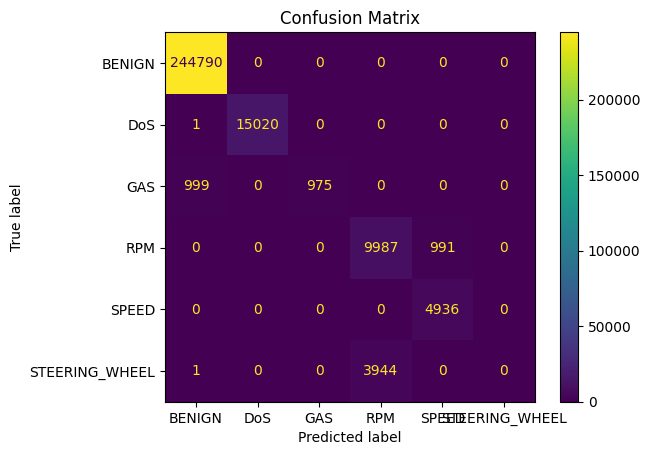

In [ ]:
import pandas as pd
import numpy as np
import collections
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/CICIoV2024/decimal.csv")

# Encode string labels into numerical values
label_mapping = {label: index for index, label in enumerate(df['specific_class'].unique())}
df['specific_class'] = df['specific_class'].map(label_mapping)

# Split the data into train and test sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Create train data for clients
def create_tf_dataset_for_client(client_data):
    data = client_data.iloc[:, 1:9].values.astype(np.float32)
    labels = client_data['specific_class'].values.astype(np.int32)
    return tf.data.Dataset.from_tensor_slices((data, labels)).batch(32)

# Split the train_df into seven parts for seven clients
client_data_splits = np.array_split(train_df, 7)

# Create TF datasets for each client
train_data = [create_tf_dataset_for_client(client_data) for client_data in client_data_splits]

# Create a TF dataset for the test data
test_data = tf.data.Dataset.from_tensor_slices(
    (test_df.iloc[:, 1:9].values.astype(np.float32), test_df['specific_class'].values.astype(np.int32))
).batch(32)

# Define the Keras model
def build_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Reshape((8, 1), input_shape=(8,)),
        tf.keras.layers.Conv1D(32, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(64, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(np.max(df['specific_class']) + 1, activation='softmax')
    ])
    return model

# Wrap a Keras model for use with TFF.
def model_fn():
    keras_model = build_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=train_data[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

# Simulate a few rounds of training with the selected client devices.
trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.001)
)

state = trainer.initialize()

# Lists to store training and testing metrics
train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []

print("Training and Testing Results")

for round_num in range(5):
    # Training
    state, metrics = trainer.next(state, train_data)

    train_accuracy = metrics['client_work']['train']['sparse_categorical_accuracy']
    train_loss = metrics['client_work']['train']['loss']
    num_examples = metrics['client_work']['train']['num_examples']
    num_batches = metrics['client_work']['train']['num_batches']
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    print(f'Round {round_num+1}, Training accuracy: {train_accuracy:.4f}, Training loss: {train_loss:.4f}, Num examples: {num_examples}, Num batches: {num_batches}')

    # Testing
    eval_process = tff.learning.build_federated_evaluation(model_fn)
    model_weights = trainer.get_model_weights(state)
    test_metrics = eval_process(model_weights, [test_data])['eval']
    test_accuracy = test_metrics['sparse_categorical_accuracy']
    test_loss = test_metrics['loss']
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)
    #print(f"Round {round_num+1}, Testing accuracy: {test_accuracy:.4f}, Testing loss: {test_loss:.4f}, Num examples: {test_metrics['num_examples']}, Num batches: {test_metrics['num_batches']}")

rounds = range(1, 6)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(rounds, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(rounds, test_accuracies, marker='o', label='Test Accuracy')
plt.title('Accuracy over Rounds')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rounds, train_losses, marker='o', label='Train Loss')
plt.plot(rounds, test_losses, marker='o', label='Test Loss')
plt.title('Loss over Rounds')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()

plt.suptitle('Federated Training and Testing Metrics')
plt.show()


# Confusion Matrix
keras_model = build_keras_model()
keras_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
keras_model.set_weights(model_weights.trainable)

y_true = np.concatenate([y for x, y in test_data], axis=0)
y_pred = np.argmax(keras_model.predict(test_data), axis=1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
disp.plot()
plt.title('Confusion Matrix')
plt.show()
